<a href="https://colab.research.google.com/github/Alton01/Text-classification-With-Tensorflow/blob/main/TextclassificationwithTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub



In [3]:
df = pd.read_csv('wine-reviews.csv', usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [5]:
df.dropna(subset=['description', 'points'])

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Pinot Gris,Domaine Marcel Deiss


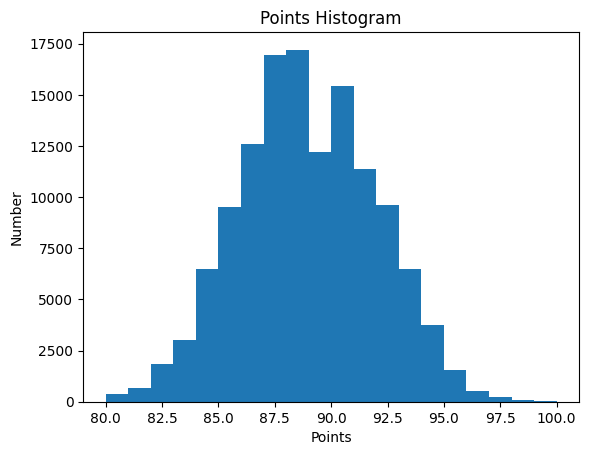

In [6]:
plt.hist(df.points, bins=20)
plt.title('Points Histogram')
plt.ylabel('Number')
plt.xlabel('Points')
plt.show()

In [7]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary sets (validation + test)
train, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets
val, test = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Training set shape:", train.shape)
print("Validation set shape:", val.shape)
print("Test set shape:", test.shape)

Training set shape: (103976, 2)
Validation set shape: (12997, 2)
Test set shape: (12998, 2)


In [9]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [11]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [12]:
#for numerical transformation

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.41742226, -0.27382573,  0.21419261, ...,  0.0365371 ,
        -0.54434717,  0.07082785],
       [ 0.41978157, -0.0670535 , -0.12814684, ..., -0.09449756,
        -0.29637766,  0.05638946],
       [ 0.31670618, -0.36838144,  0.00604731, ..., -0.11085526,
        -0.10130753,  0.13800848],
       ...,
       [ 0.23602934, -0.2564736 , -0.22806583, ..., -0.15040965,
        -0.04592568, -0.1452029 ],
       [ 0.4353345 , -0.1032138 ,  0.09506856, ...,  0.11851788,
        -0.21219486,  0.05519112],
       [ 0.531348  , -0.0893151 ,  0.01901276, ...,  0.08786003,
         0.05466223, -0.06781836]], dtype=float32)>

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: hub_layer(x)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3781 - loss: 0.8015


[0.8017265796661377, 0.37755829095840454]

In [18]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3848 - loss: 0.7956


[0.7978171706199646, 0.3824728727340698]

In [19]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5025 - loss: 0.7086 - val_accuracy: 0.6266 - val_loss: 0.6444
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6409 - loss: 0.6353 - val_accuracy: 0.6803 - val_loss: 0.6018
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6795 - loss: 0.5987 - val_accuracy: 0.6998 - val_loss: 0.5769
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6941 - loss: 0.5810 - val_accuracy: 0.7059 - val_loss: 0.5673
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7006 - loss: 0.5732 - val_accuracy: 0.7080 - val_loss: 0.5634
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7046 - loss: 0.5693 - val_accuracy: 0.7087 - val_loss: 0.5621
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7041 - loss: 0.5679 - val_accuracy: 0.7106 - val_loss: 0.5589
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7060 - loss: 0.5651 - val_accu